## <b> 1. Giới thiệu bài toán và dữ liệu </b>

**Bối cảnh dự án:**
Dự án này tập trung vào việc xây dựng một mô hình dự báo nhiệt độ không khí tối thiểu (Next_Tmin) cho ngày tiếp theo tại Hà Nội. Việc dự báo nhiệt độ chính xác có ý nghĩa quan trọng trong nhiều lĩnh vực như nông nghiệp, năng lượng, du lịch và đời sống hàng ngày.

**Thông tin tập dữ liệu:**
Tập dữ liệu được sử dụng là `hanoi weather - Hanoi.csv`, chứa thông tin thời tiết lịch sử tại Hà Nội qua nhiều năm. Dữ liệu bao gồm các khí tượng cơ bản như nhiệt độ (hiện tại, tối đa, tối thiểu), độ ẩm, lượng mưa, tốc độ và hướng gió, áp suất mực nước biển, độ che phủ mây, và tầm nhìn. Ngoài ra, tập dữ liệu còn có các đặc trưng được tạo ra (feature engineered) như giá trị trễ (lag features), trung bình trượt (rolling averages), và các chỉ số so sánh theo tháng/ngày trong năm, nhằm cung cấp thêm thông tin ngữ cảnh cho mô hình.
**Nguồn dữ liệu:**  
Dữ liệu được thu thập từ [Visual Crossing Weather Data](https://www.visualcrossing.com/) với thông tin thời tiết tại Hà Nội trong khoảng thời gian từ **15/01/1998 đến 28/04/2025**.

**Mục tiêu tiền xử lý:**
Mục tiêu chính của notebook này là thực hiện quy trình tiền xử lý dữ liệu (data preprocessing) một cách toàn diện. Quy trình này bao gồm các bước làm sạch dữ liệu, xử lý giá trị thiếu, phát hiện và xử lý giá trị ngoại lai, xử lý độ lệch, kiểm tra và giảm thiểu đa cộng tuyến, và chuẩn hóa dữ liệu. Kết quả cuối cùng là một tập dữ liệu sạch, có cấu trúc tốt, và sẵn sàng cho việc huấn luyện các mô hình học máy để dự báo nhiệt độ. Biến mục tiêu chính cần dự báo là `target_tempmin`.


In [3]:
import matplotlib
matplotlib.use('Agg')
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, PowerTransformer
from scipy.stats import zscore
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns # For Visualization
import matplotlib.pyplot as plt # ploting package
%matplotlib inline
import warnings # Filtering warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

# <b> 2. Đọc dữ liệu và kiểm tra tổng quan </b>

**Mục tiêu:**
Bước đầu tiên là tải dữ liệu từ file `hanoi weather - Hanoi.csv` vào một DataFrame của Pandas. Sau đó, thực hiện một số kiểm tra sơ bộ để hiểu rõ hơn về cấu trúc và nội dung ban đầu của dữ liệu.

**Các bước thực hiện:**
-   **Đọc dữ liệu:** Sử dụng `pd.read_csv()` để tải dữ liệu.
-   **Kiểm tra kích thước:** Xem xét số lượng hàng và cột (`df.shape`) để biết quy mô của tập dữ liệu.
-   **Xem lướt dữ liệu:** Hiển thị 5 dòng đầu tiên (`df.head()`) để có cái nhìn trực quan về các cột và giá trị mẫu.
-   **Kiểu dữ liệu:** Kiểm tra kiểu dữ liệu của từng cột (`df.dtypes` hoặc `df.info()`) để xác định các cột số, cột chuỗi, hoặc cột thời gian cần xử lý đặc biệt.
-   **Kiểm tra trùng lặp:** Xác định và đánh giá số lượng các hàng bị trùng lặp hoàn toàn (`df.duplicated().sum()`).
-   **Kiểm tra giá trị đặc biệt/rỗng trá hình:** Tìm kiếm các giá trị như chuỗi rỗng (' '), 'NA', hoặc '-' có thể tồn tại trong dữ liệu và cần được xử lý như giá trị thiếu.

In [12]:

# Đọc dữ liệu
df = pd.read_csv('../data/raw/hanoi weather - Hanoi.csv', encoding='utf-8')


Shape: (9873, 46)

Thông tin kiểu dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9873 entries, 0 to 9872
Data columns (total 46 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   datetime               9873 non-null   object 
 1   temp                   9873 non-null   float64
 2   tempmax                9873 non-null   float64
 3   tempmin                9873 non-null   object 
 4   dew                    9873 non-null   float64
 5   humidity               9873 non-null   float64
 6   precip                 9873 non-null   float64
 7   windspeed              9873 non-null   float64
 8   winddir                9873 non-null   float64
 9   sealevelpressure       9873 non-null   float64
 10  cloudcover             9873 non-null   float64
 11  visibility             9873 non-null   float64
 12  month                  9873 non-null   int64  
 13  dayofyear              9873 non-null   float64
 14  temp_roll_mea

,datetime,temp,tempmax,tempmin,dew,humidity,precip,windspeed,winddir,sealevelpressure,...,monthly_avg_tempmax,monthly_avg_tempmin,doy_avg_tempmax,doy_avg_tempmin,tempmax_vs_month_avg,tempmin_vs_month_avg,tempmax_vs_doy_avg,tempmin_vs_doy_avg,target_tempmax,target_tempmin
0,1998-01-15,16.4,19.1,13.111.3,72.6,1.0,24.3,71.5,1010.1,85.1,...,18.960000,19.100000,13.1,-6.2,-5.860000,0.000000,0.0,21.1,17.1,NaN
1,1998-01-16,19.0,21.1,17.1,16.3,84.4,0.0,18.0,77.4,1006.4,...,25.037500,18.843750,21.1,17.1,-3.937500,-1.743750,0.0,0.0,22.1,17.1
2,1998-01-17,19.7,22.1,17.1,13.6,68.9,0.0,28.8,66.4,1012.0,...,24.864706,18.741176,22.1,17.1,-2.764706,-1.641176,0.0,0.0,24.1,14.1
3,1998-01-18,15.5,24.1,14.1,8.7,64.9,0.0,25.2,63.2,1017.2,...,24.822222,18.483333,24.1,14.1,-0.722222,-4.383333,0.0,0.0,13.1,10.1
4,1998-01-19,11.5,13.1,10.1,8.8,83.8,0.1,21.6,47.0,1021.0,...,24.205263,18.042105,13.1,10.1,-11.105263,-7.942105,0.0,0.0,13.1,10.0


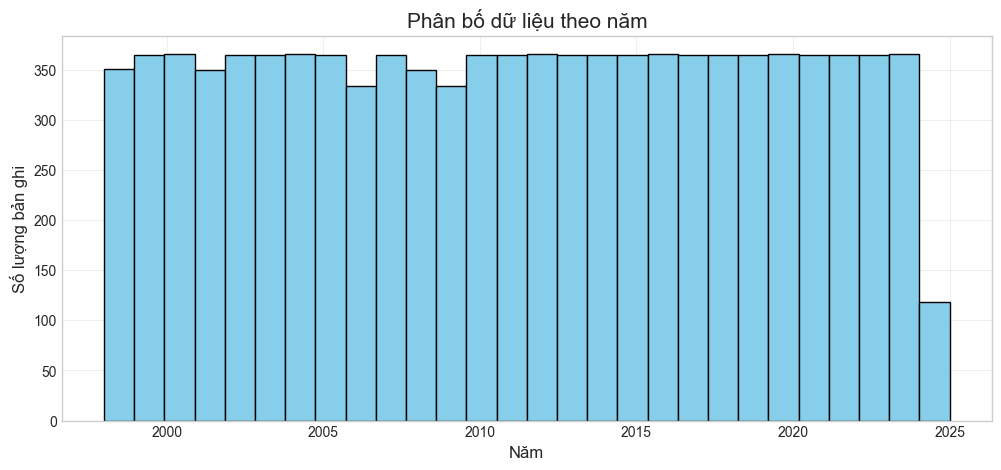

In [13]:
# Hiển thị thông tin cơ bản về dữ liệu
print(f"Shape: {df.shape}")
print("\nThông tin kiểu dữ liệu:")
print(df.info())

# Kiểm tra các giá trị đầu tiên
print("\n5 dòng đầu tiên:")
display(df.head())

# Tạo biểu đồ phân bổ các giá trị trong cột datetime
plt.figure(figsize=(12, 5))
df['datetime'] = pd.to_datetime(df['datetime'])
years = df['datetime'].dt.year
plt.hist(years, bins=len(years.unique()), color='skyblue', edgecolor='black')
plt.title('Phân bố dữ liệu theo năm', fontsize=15)
plt.xlabel('Năm', fontsize=12)
plt.ylabel('Số lượng bản ghi', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

# <b> 3. Danh sách đặc trưng số </b>

**Mục tiêu:**
Xác định và liệt kê tất cả các đặc trưng dạng số (numeric features) sẽ được sử dụng và xử lý trong pipeline. Điều này bao gồm cả các đặc trưng gốc từ dữ liệu đầu vào và các đặc trưng được tạo ra thông qua feature engineering (ví dụ: rolling mean, lag features, các đặc trưng so sánh với trung bình tháng/ngày).

**Tầm quan trọng:**
Việc có một danh sách rõ ràng các đặc trưng số giúp:
-   Đảm bảo tính nhất quán trong các bước xử lý tiếp theo (ví dụ: xử lý giá trị thiếu, ngoại lai, skewness, chuẩn hóa chỉ áp dụng cho các cột số).
-   Dễ dàng theo dõi và quản lý các đặc trưng trong suốt quá trình.
-   Cải thiện khả năng đọc hiểu và bảo trì code.

Các đặc trưng này sẽ là đầu vào chính cho các thuật toán học máy sau này.



In [14]:

# Danh sách đặc trưng số
numeric_columns = [
    'temp', 'tempmax', 'tempmin', 'dew', 'humidity', 'precip', 'windspeed',
    'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
    'temp_roll_mean_3', 'humidity_roll_mean_3', 'precip_roll_mean_3',
    'temp_roll_mean_7', 'humidity_roll_mean_7', 'precip_roll_mean_7',
    'temp_roll_mean_14', 'humidity_roll_mean_14', 'precip_roll_mean_14',
    'temp_pct_diff_3', 'humidity_pct_diff_3', 'temp_pct_diff_7', 'humidity_pct_diff_7',
    'temp_lag_1', 'humidity_lag_1', 'precip_lag_1',
    'temp_lag_2', 'humidity_lag_2', 'precip_lag_2',
    'temp_lag_3', 'humidity_lag_3', 'precip_lag_3',
    'monthly_avg_tempmax', 'monthly_avg_tempmin',
    'doy_avg_tempmax', 'doy_avg_tempmin',
    'tempmax_vs_month_avg', 'tempmin_vs_month_avg',
    'tempmax_vs_doy_avg', 'tempmin_vs_doy_avg',
    'target_tempmax', 'target_tempmin'
]

print("\n=== TIỀN XỬ LÝ DỮ LIỆU ===")



=== TIỀN XỬ LÝ DỮ LIỆU ===


# <b> 4. Loại bỏ hàng trống </b>

**Mục tiêu:**
Loại bỏ các hàng mà tất cả các giá trị đều là rỗng (NaN). Những hàng như vậy không cung cấp thông tin hữu ích và có thể gây lỗi trong các bước xử lý hoặc huấn luyện mô hình sau này.

**Phương pháp:**
Sử dụng phương thức `dropna(how='all')` của Pandas. Tham số `how='all'` chỉ định rằng một hàng chỉ bị loại bỏ nếu tất cả các giá trị trong hàng đó là NaN.

**Đánh giá:**
So sánh số lượng hàng trước và sau khi thực hiện thao tác này để biết có bao nhiêu hàng hoàn toàn trống đã được loại bỏ. Thông thường, số lượng này không lớn nếu dữ liệu được thu thập tốt.





In [15]:

# 1. Loại bỏ hàng trống
print("\n1. Loại bỏ hàng trống:")
initial_rows = len(df)
df = df.dropna(how='all')
print(f"- Số hàng ban đầu: {initial_rows}")
print(f"- Số hàng sau khi loại bỏ hàng trống: {len(df)}")



1. Loại bỏ hàng trống:
- Số hàng ban đầu: 9873
- Số hàng sau khi loại bỏ hàng trống: 9873


# <b> 5. Xử lý giá trị thiếu </b>

**Mục tiêu:**
Phát hiện và xử lý các giá trị thiếu (NaN) trong các cột đặc trưng số. Giá trị thiếu là một vấn đề phổ biến trong dữ liệu thực tế và cần được xử lý cẩn thận để tránh làm giảm hiệu suất hoặc gây lỗi cho mô hình học máy.

**Quy trình xử lý:**
1.  **Chuyển đổi kiểu dữ liệu:** Đảm bảo tất cả các cột trong `numeric_columns` được chuyển đổi sang kiểu số (`pd.to_numeric`), với các giá trị không hợp lệ được chuyển thành NaN (`errors='coerce'`).
2.  **Tạo đặc trưng Lag (nếu cần):** Đối với các đặc trưng chuỗi thời gian như 'temp', 'humidity', 'precip', các giá trị trễ (lagged values) từ các ngày trước đó có thể là những yếu tố dự báo quan trọng. Nếu các cột lag chưa tồn tại hoặc có giá trị thiếu, chúng sẽ được tạo/điền bằng cách dịch chuyển (shift) giá trị của cột gốc.
3.  **Điền giá trị thiếu cho cột Lag:**
    *   Sử dụng `fillna(method='bfill')` (backfill): Điền giá trị thiếu bằng giá trị hợp lệ tiếp theo trong cột.
    *   Sử dụng `fillna(method='ffill')` (forwardfill): Điền giá trị thiếu bằng giá trị hợp lệ trước đó trong cột.
    *   Sử dụng `fillna(df[col].median())`: Điền các giá trị thiếu còn lại bằng giá trị trung vị của cột. Sự kết hợp này giúp duy trì tính liên tục của chuỗi thời gian và robust với outlier.
4.  **Điền giá trị thiếu cho các cột số còn lại:** Đối với các cột số không phải là lag feature, điền giá trị thiếu bằng trung vị (`median`) của cột đó. Trung vị được ưu tiên hơn trung bình cộng vì nó ít bị ảnh hưởng bởi các giá trị ngoại lai.
5.  **Xử lý giá trị thiếu ở biến mục tiêu:** Loại bỏ hoàn toàn các hàng có giá trị thiếu trong cột mục tiêu (`target_tempmin`) bằng `dropna()`. Điều này rất quan trọng vì chúng ta không thể huấn luyện mô hình hoặc đánh giá hiệu suất nếu không có giá trị mục tiêu.

**Đánh giá:**
Kiểm tra lại số lượng giá trị thiếu trong các cột `numeric_columns` sau khi xử lý để đảm bảo tất cả đã được điền hoặc loại bỏ một cách hợp lý. So sánh số lượng hàng trước và sau khi xử lý giá trị thiếu ở biến mục tiêu.




In [16]:

# 2. Xử lý giá trị thiếu
print("\n2. Xử lý giá trị thiếu:")
print("- Giá trị thiếu trước xử lý:")
print(df[numeric_columns].isnull().sum())

# Chuyển đổi kiểu dữ liệu các cột số
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Xử lý tất cả các cột lag nếu chúng chưa tồn tại trong dữ liệu
lag_features = {
    'temp': ['temp_lag_1', 'temp_lag_2', 'temp_lag_3'],
    'humidity': ['humidity_lag_1', 'humidity_lag_2', 'humidity_lag_3'],
    'precip': ['precip_lag_1', 'precip_lag_2', 'precip_lag_3']
}

# Tạo các cột lag nếu chưa tồn tại
for source_col, lag_cols in lag_features.items():
    for i, lag_col in enumerate(lag_cols, 1):
        if lag_col not in df.columns or df[lag_col].isnull().sum() > 0:
            df[lag_col] = df[source_col].shift(i)

# Điền giá trị thiếu cho các cột lag
all_lag_cols = [col for sublist in lag_features.values() for col in sublist]
for col in all_lag_cols:
    df[col] = df[col].fillna(method='bfill')
    df[col] = df[col].fillna(method='ffill')
    df[col] = df[col].fillna(df[col].median())

# Điền giá trị thiếu cho các cột còn lại
for col in numeric_columns:
    if col not in all_lag_cols:
        df[col] = df[col].fillna(df[col].median())

# Đảm bảo không có giá trị thiếu trong target
df = df.dropna(subset=['target_tempmax', 'target_tempmin'])

print("- Giá trị thiếu sau xử lý:")
print(df[numeric_columns].isnull().sum())
print(f"- Số hàng sau khi xử lý target: {len(df)}")



2. Xử lý giá trị thiếu:
- Giá trị thiếu trước xử lý:
temp                     0
tempmax                  0
tempmin                  0
dew                      0
humidity                 0
precip                   0
windspeed                0
winddir                  0
sealevelpressure         0
cloudcover               0
visibility               0
temp_roll_mean_3         0
humidity_roll_mean_3     0
precip_roll_mean_3       0
temp_roll_mean_7         0
humidity_roll_mean_7     0
precip_roll_mean_7       0
temp_roll_mean_14        0
humidity_roll_mean_14    0
precip_roll_mean_14      0
temp_pct_diff_3          0
humidity_pct_diff_3      0
temp_pct_diff_7          0
humidity_pct_diff_7      0
temp_lag_1               0
humidity_lag_1           0
precip_lag_1             0
temp_lag_2               0
humidity_lag_2           0
precip_lag_2             0
temp_lag_3               0
humidity_lag_3           0
precip_lag_3             0
monthly_avg_tempmax      0
monthly_avg_tempmin      0
d

# <b> 6. Chuyển đổi kiểu dữ liệu datetime </b>

**Mục tiêu:**
Chuyển đổi cột `datetime` từ kiểu chuỗi (object) hoặc số sang kiểu dữ liệu datetime chuẩn của Pandas (`pd.to_datetime`).

**Tầm quan trọng:**
Việc có cột `datetime` ở định dạng chuẩn là rất cần thiết vì nó cho phép:
-   Dễ dàng trích xuất các thành phần thời gian hữu ích như năm, tháng, ngày, ngày trong tuần, ngày trong năm, v.v. (ví dụ: `df['datetime'].dt.month`).
-   Thực hiện các phép toán và so sánh dựa trên thời gian.
-   Sử dụng làm chỉ số (index) cho DataFrame nếu cần phân tích chuỗi thời gian nâng cao.
-   Tạo các đặc trưng dựa trên thời gian một cách chính xác (ví dụ: rolling mean theo cửa sổ thời gian).

**Xử lý lỗi:**
Tham số `errors='coerce'` được sử dụng để nếu có bất kỳ giá trị nào trong cột `datetime` không thể chuyển đổi thành ngày tháng hợp lệ, nó sẽ được đặt thành `NaT` (Not a Time). Sau đó, các hàng chứa `NaT` trong cột `datetime` sẽ được loại bỏ (`dropna(subset=['datetime'])`) để đảm bảo tính nhất quán của dữ liệu.




In [17]:

# 3. Chuyển đổi kiểu dữ liệu datetime
print("\n3. Chuyển đổi kiểu dữ liệu:")
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
df = df.dropna(subset=['datetime'])
print("- Đã chuyển cột datetime sang định dạng datetime.")
print(f"- Số hàng sau khi xử lý datetime: {len(df)}")



3. Chuyển đổi kiểu dữ liệu:
- Đã chuyển cột datetime sang định dạng datetime.
- Số hàng sau khi xử lý datetime: 9873


# <b> 7. Thống kê mô tả dữ liệu </b>

**Mục tiêu:**
Thực hiện thống kê mô tả (descriptive statistics) cho các đặc trưng số quan trọng, đặc biệt là các biến mục tiêu và các yếu tố thời tiết chính như 'precip', 'humidity', 'windspeed'.

**Phương pháp:**
Sử dụng phương thức `describe()` của Pandas. Kết quả sẽ bao gồm các thông số như:
-   `count`: Số lượng giá trị không thiếu.
-   `mean`: Giá trị trung bình.
-   `std`: Độ lệch chuẩn (mô tả mức độ phân tán của dữ liệu).
-   `min`: Giá trị nhỏ nhất.
-   `25%` (Q1): Tứ phân vị thứ nhất.
-   `50%` (median/Q2): Trung vị (Tứ phân vị thứ hai).
-   `75%` (Q3): Tứ phân vị thứ ba.
-   `max`: Giá trị lớn nhất.

**Phân tích và nhận xét:**
-   **Phân bố dữ liệu:** Xem xét giá trị trung bình và trung vị. Nếu chúng gần nhau, dữ liệu có thể phân bố đối xứng. Sự khác biệt lớn có thể chỉ ra độ lệch (skewness).
-   **Phạm vi giá trị:** Kiểm tra `min` và `max` để phát hiện các giá trị bất thường hoặc không hợp lý. Ví dụ, độ ẩm không thể < 0% hoặc > 100%, lượng mưa không thể âm.
-   **Độ biến động:** Độ lệch chuẩn (`std`) cho biết mức độ dao động của dữ liệu quanh giá trị trung bình.
-   **So sánh với kiến thức thực tế:** Đối chiếu các giá trị thống kê (đặc biệt là min, max, mean của nhiệt độ, độ ẩm, lượng mưa) với kiến thức thông thường về thời tiết Hà Nội để đánh giá tính hợp lý của dữ liệu. Ví dụ, nhiệt độ tối đa khó có thể vượt quá 45°C hoặc tối thiểu dưới 0°C ở Hà Nội trong điều kiện thông thường.

Bước này giúp xác định các vấn đề tiềm ẩn về chất lượng dữ liệu và định hướng cho các bước xử lý giá trị bất thường (clipping) hoặc ngoại lai (outlier removal) tiếp theo.




,target_tempmax,target_tempmin,precip,humidity,windspeed
count,9873.000000,9873.000000,9873.000000,9873.000000,9873.000000
mean,27.930295,21.369857,4.515906,79.615375,17.845954
std,5.867978,4.998789,14.752068,10.540962,5.828276
min,8.000000,3.800000,0.000000,1.000000,4.200000
25%,24.000000,18.000000,0.000000,73.700000,14.400000
50%,29.000000,23.000000,0.100000,80.900000,17.500000
75%,32.800000,25.100000,1.500000,87.000000,21.600000
max,43.100000,31.000000,331.243000,100.000000,79.200000


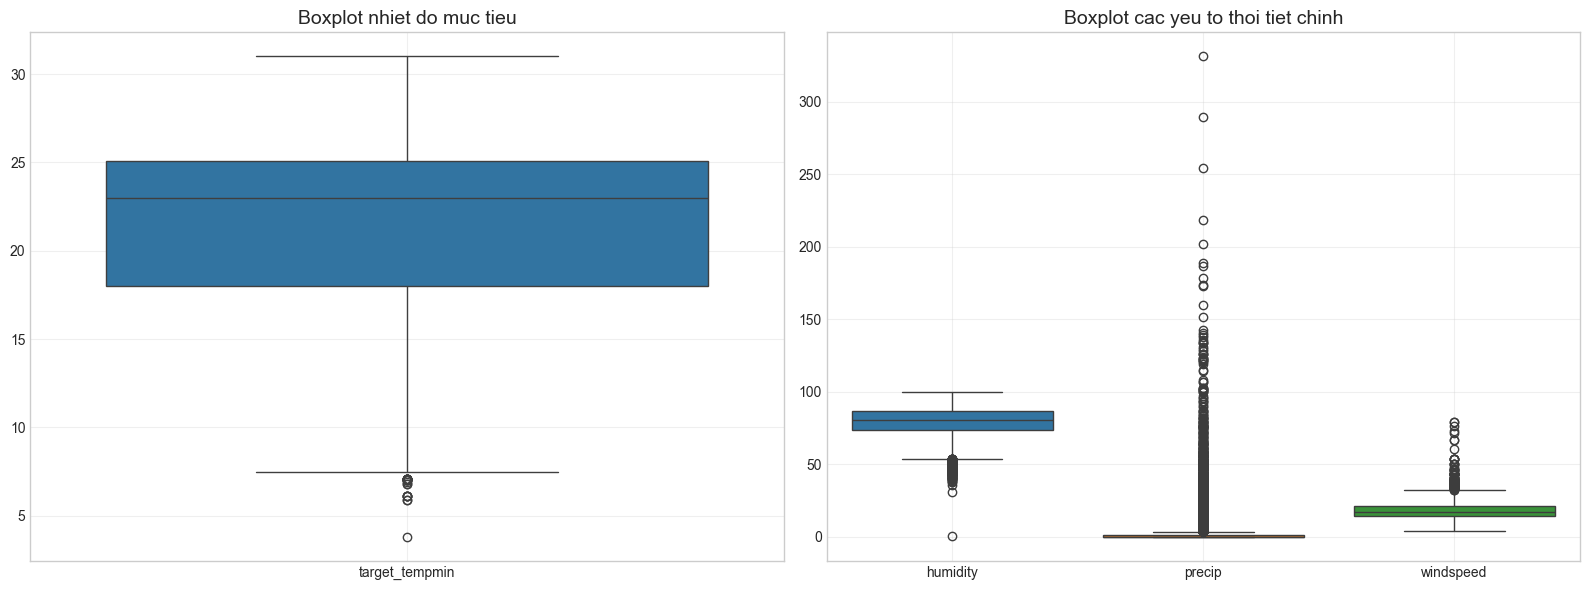

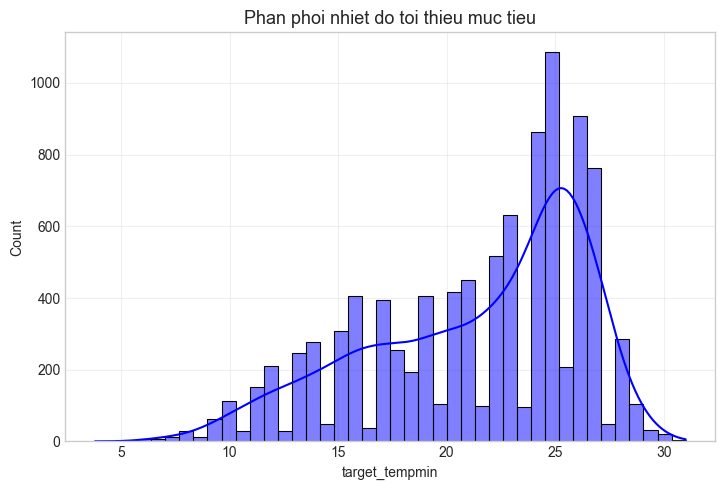

In [18]:
# Hiển thị thống kê mô tả
desc_stats = df[['target_tempmax', 'target_tempmin', 'precip', 'humidity', 'windspeed']].describe()
display(desc_stats)

# Vẽ boxplot cho các biến quan trọng
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
sns.boxplot(data=df[['target_tempmin']])
plt.title('Boxplot nhiet do muc tieu', fontsize=14)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
sns.boxplot(data=df[['humidity', 'precip', 'windspeed']])
plt.title('Boxplot cac yeu to thoi tiet chinh', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Histogram cho nhiệt độ mục tiêu
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 2)
sns.histplot(df['target_tempmin'], kde=True, color='blue')
plt.title('Phan phoi nhiet do toi thieu muc tieu', fontsize=13)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [19]:

# 4. Kiểm tra dữ liệu trước khi xử lý bất thường
print("\n4. Kiểm tra dữ liệu trước khi xử lý bất thường:")
print("- Thống kê mô tả cho các cột quan trọng:")
print(df[['target_tempmax', 'target_tempmin', 'precip', 'humidity', 'windspeed']].describe())



4. Kiểm tra dữ liệu trước khi xử lý bất thường:
- Thống kê mô tả cho các cột quan trọng:
       target_tempmax  target_tempmin       precip     humidity    windspeed
count     9873.000000     9873.000000  9873.000000  9873.000000  9873.000000
mean        27.930295       21.369857     4.515906    79.615375    17.845954
std          5.867978        4.998789    14.752068    10.540962     5.828276
min          8.000000        3.800000     0.000000     1.000000     4.200000
25%         24.000000       18.000000     0.000000    73.700000    14.400000
50%         29.000000       23.000000     0.100000    80.900000    17.500000
75%         32.800000       25.100000     1.500000    87.000000    21.600000
max         43.100000       31.000000   331.243000   100.000000    79.200000


# <b> 8. Xử lý giá trị bất thường (clip) </b>

**Mục tiêu:**
Giới hạn (clip) giá trị của một số đặc trưng số vào một phạm vi hợp lý dựa trên kiến thức chuyên môn hoặc các quy tắc thực tế. Điều này giúp loại bỏ hoặc điều chỉnh các giá trị cực đoan có thể do lỗi nhập liệu, lỗi cảm biến, hoặc các sự kiện hiếm gặp không đại diện cho xu hướng chung.

**Phương pháp:**
Sử dụng phương thức `clip(lower=min_val, upper=max_val)` của Pandas. Các giá trị nhỏ hơn `min_val` sẽ được thay thế bằng `min_val`, và các giá trị lớn hơn `max_val` sẽ được thay thế bằng `max_val`.

**Các cột được xử lý và phạm vi clip ví dụ:**
-   `humidity`: Clip trong khoảng [20, 100]. Độ ẩm thường không dưới 20% và không thể quá 100%.
-   `precip`: Clip trong khoảng [0, 500]. Lượng mưa không thể âm, và 500mm là một giới hạn trên rất lớn cho lượng mưa trong một ngày.
-   `windspeed`: Clip trong khoảng [0, 50]. Tốc độ gió không âm, và 50 m/s (180 km/h) là một tốc độ gió rất mạnh, có thể coi là giới hạn trên.
-   `target_tempmax`: Clip trong khoảng [15, 38]. Nhiệt độ tối đa ở Hà Nội hiếm khi dưới 15°C hoặc trên 38°C (trong dữ liệu mùa hè).
-   `target_tempmin`: Clip trong khoảng [8, 32]. Nhiệt độ tối thiểu ở Hà Nội hiếm khi dưới 8°C hoặc trên 32°C.

**Lọc bổ sung:**
Sau khi clip, một bước lọc bổ sung có thể được áp dụng để loại bỏ các hàng vẫn chứa giá trị nằm ngoài một phạm vi mong muốn hẹp hơn một chút (ví dụ, `humidity` từ 20% đến 95% thay vì 100% để loại bỏ các trường hợp bão hòa hoàn toàn kéo dài). Điều này giúp làm mịn dữ liệu hơn nữa.

**Đánh giá:**
So sánh số lượng hàng trước và sau khi clip và lọc để biết có bao nhiêu dữ liệu bị ảnh hưởng. Kiểm tra lại thống kê mô tả của các cột đã clip để đảm bảo các giá trị nằm trong phạm vi mong muốn.




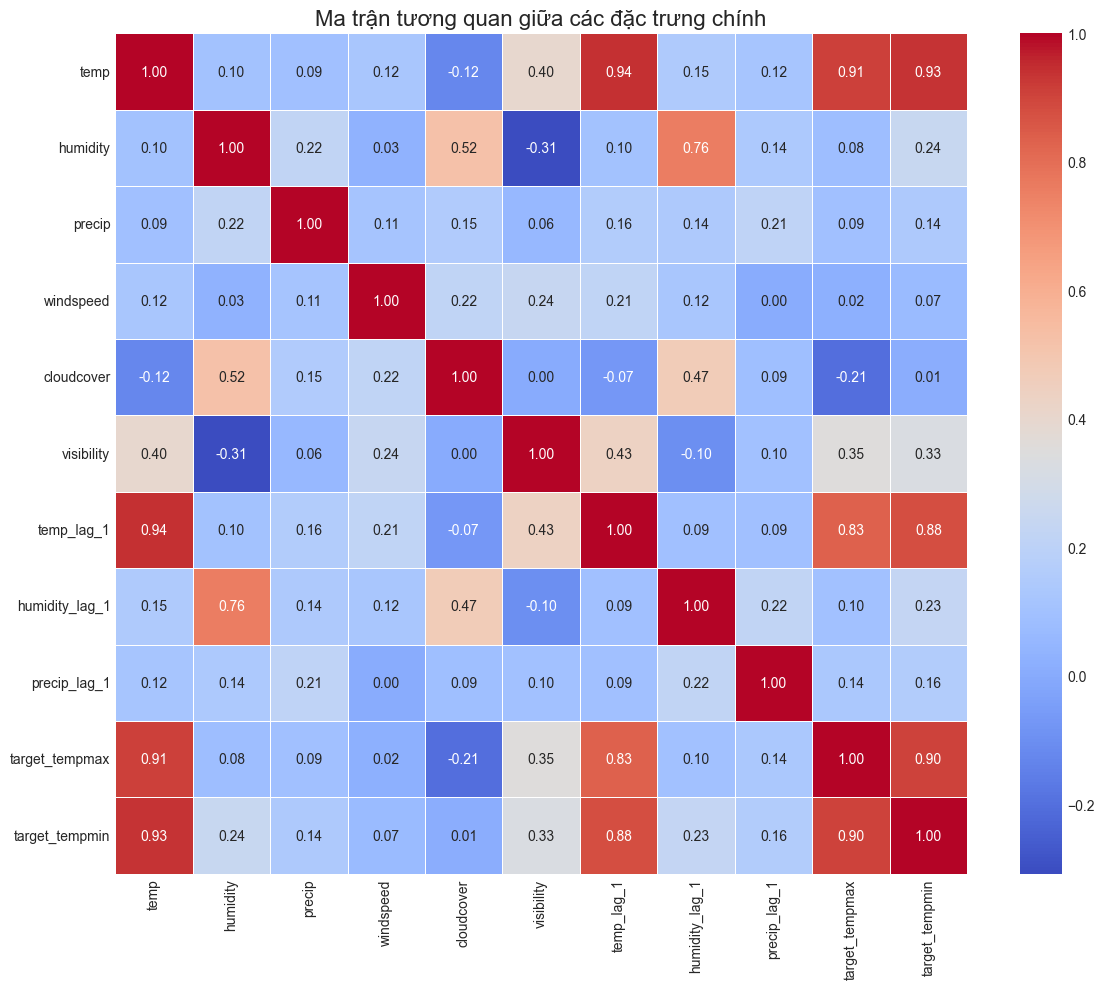

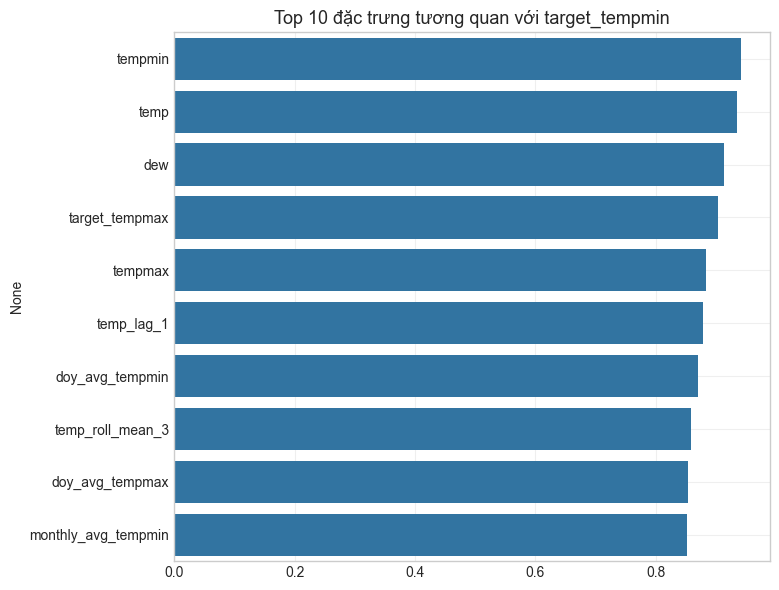

In [20]:
# Tạo ma trận tương quan cho các biến chính
corr_columns = ['temp', 'humidity', 'precip', 'windspeed', 'cloudcover', 'visibility',
               'temp_lag_1', 'humidity_lag_1', 'precip_lag_1',
               'target_tempmax', 'target_tempmin']
corr_matrix = df[corr_columns].corr()

# Vẽ heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Ma trận tương quan giữa các đặc trưng chính', fontsize=16)
plt.tight_layout()
plt.show()

# Biểu đồ tương quan với biến mục tiêu
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 2)
corr_with_target_min = df.corr()['target_tempmin'].sort_values(ascending=False)
corr_with_target_min = corr_with_target_min.drop('target_tempmin')
sns.barplot(x=corr_with_target_min.values[:10], y=corr_with_target_min.index[:10])
plt.title('Top 10 đặc trưng tương quan với target_tempmin', fontsize=13)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

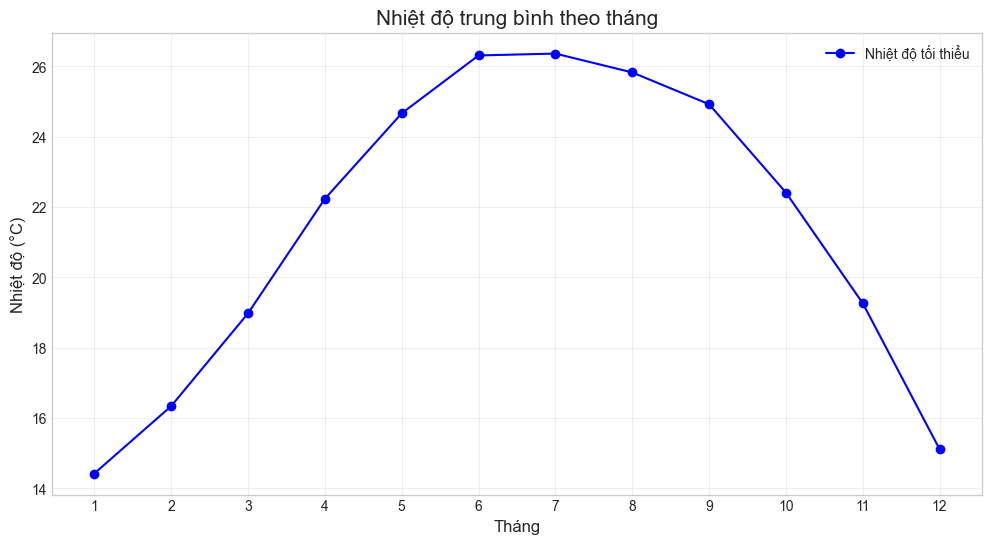

In [21]:
# Thêm cột tháng và năm
df['month'] = df['datetime'].dt.month
df['year'] = df['datetime'].dt.year

# Biểu đồ nhiệt độ trung bình theo tháng
monthly_temp = df.groupby('month')[['target_tempmin']].mean().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(monthly_temp['month'], monthly_temp['target_tempmin'], 'bo-', label='Nhiệt độ tối thiểu')
plt.title('Nhiệt độ trung bình theo tháng', fontsize=15)
plt.xlabel('Tháng', fontsize=12)
plt.ylabel('Nhiệt độ (°C)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(range(1, 13))
plt.show()

In [22]:

# 5. Xử lý giá trị bất thường bằng clip
print("\n5. Xử lý giá trị bất thường:")
initial_rows = len(df)

# Clip giá trị nằm ngoài phạm vi hợp lý
df['humidity'] = df['humidity'].clip(lower=20, upper=100)
df['precip'] = df['precip'].clip(lower=0, upper=500)
df['windspeed'] = df['windspeed'].clip(lower=0, upper=50)
df['target_tempmax'] = df['target_tempmax'].clip(lower=15, upper=38)
df['target_tempmin'] = df['target_tempmin'].clip(lower=8, upper=32)


# Lọc bỏ các hàng vẫn còn giá trị bất thường sau khi clip
df = df[(df['humidity'] >= 20) & (df['humidity'] <= 95)]
df = df[(df['precip'] >= 0) & (df['precip'] <= 500)]
df = df[(df['windspeed'] >= 0) & (df['windspeed'] <= 50)]
df = df[(df['target_tempmax'] >= 10) & (df['target_tempmax'] <= 40)]
df = df[(df['target_tempmin'] >= 5) & (df['target_tempmin'] <= 35)]




5. Xử lý giá trị bất thường:


# <b> 9. Tạo đặc trưng góc gió </b>

**Mục tiêu:**
Chuyển đổi đặc trưng hướng gió (`winddir`), thường được biểu diễn bằng độ (0-360°), thành hai thành phần `winddir_sin` và `winddir_cos`.

**Lý do và Tầm quan trọng:**
Hướng gió là một đặc trưng có tính chu kỳ (cyclical). Ví dụ, 359° rất gần với 1°, nhưng nếu sử dụng trực tiếp giá trị độ, mô hình học máy có thể hiểu sai rằng chúng rất khác nhau. Bằng cách chuyển đổi sang thành phần sin và cos:
-   **Biểu diễn tính chu kỳ:** `sin(0°) = sin(360°)`, `cos(0°) = cos(360°)`. Điều này giúp mô hình nhận biết được tính liên tục của hướng gió.
-   **Tránh thứ tự giả:** Mô hình sẽ không gán một thứ tự tuyến tính không có thật cho các giá trị hướng gió.
-   **Cung cấp thông tin không gian:** Cặp giá trị (sin, cos) có thể được coi là tọa độ trên một vòng tròn đơn vị, biểu diễn hướng gió một cách tự nhiên hơn.

**Phương pháp:**
1.  Chuyển đổi góc từ độ sang radian: `radians = degrees * (π / 180)`.
2.  Tính sin của góc radian: `winddir_sin = np.sin(np.radians(df['winddir']))`.
3.  Tính cos của góc radian: `winddir_cos = np.cos(np.radians(df['winddir']))`.

Hai đặc trưng mới này (`winddir_sin`, `winddir_cos`) sẽ thay thế hoặc bổ sung cho cột `winddir` gốc trong các bước mô hình hóa tiếp theo.




In [23]:
# Thêm các đặc trưng góc gió
df['winddir_sin'] = np.sin(np.radians(df['winddir']))
df['winddir_cos'] = np.cos(np.radians(df['winddir']))

print(f"- Số hàng trước xử lý bất thường: {initial_rows}")
print(f"- Số hàng sau xử lý bất thường: {len(df)}")

- Số hàng trước xử lý bất thường: 9873
- Số hàng sau xử lý bất thường: 9450


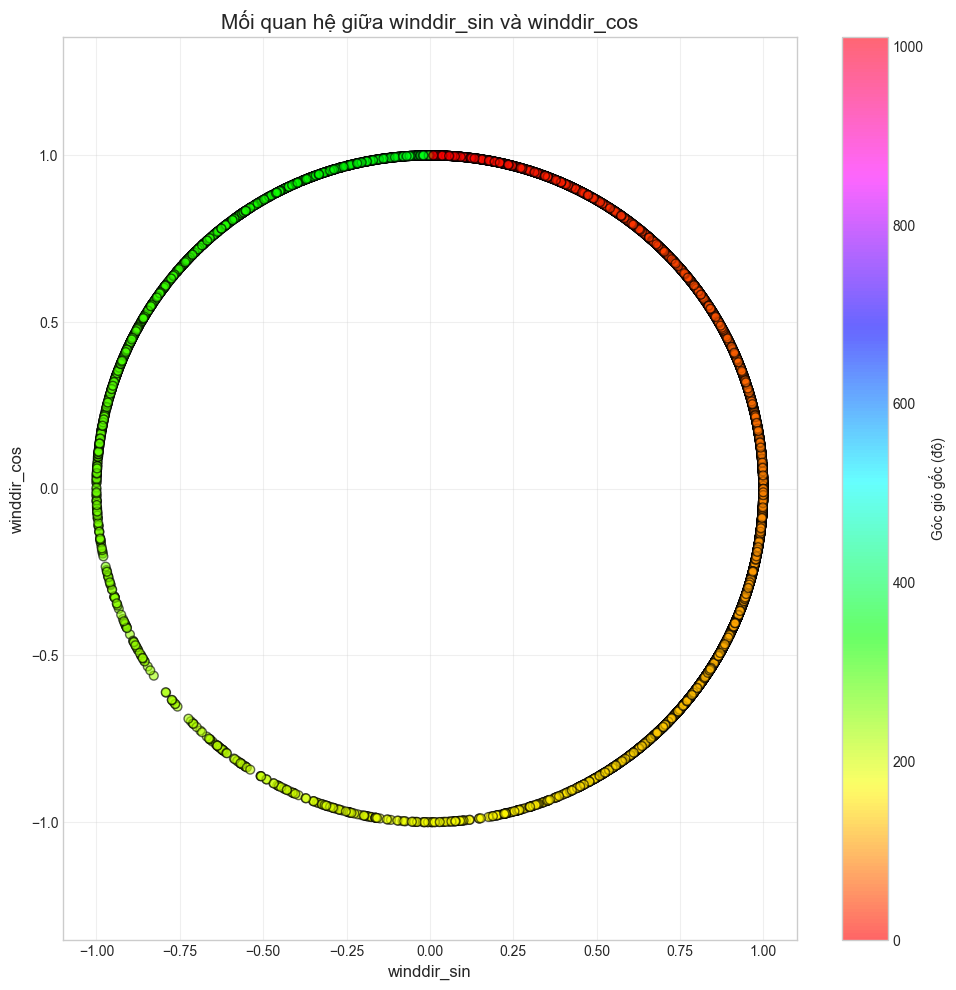

In [24]:
# Hiển thị biểu đồ mối quan hệ giữa sin/cos của góc gió
plt.figure(figsize=(10, 10))
plt.scatter(df['winddir_sin'], df['winddir_cos'], alpha=0.6,
            c=df['winddir'], cmap='hsv', s=40, edgecolor='k')
plt.colorbar(label='Góc gió gốc (độ)')
plt.title('Mối quan hệ giữa winddir_sin và winddir_cos', fontsize=15)
plt.xlabel('winddir_sin', fontsize=12)
plt.ylabel('winddir_cos', fontsize=12)
plt.grid(True, alpha=0.3)
plt.axis('equal')  # đảm bảo vòng tròn xuất hiện như mong muốn
plt.tight_layout()
plt.show()

# <b> 10. Xử lý ngoại lai (outlier) bằng Z-score </b>

**Mục tiêu:**
Phát hiện và loại bỏ các điểm dữ liệu ngoại lai (outliers) trong các đặc trưng số. Ngoại lai là những giá trị khác biệt đáng kể so với phần lớn các giá trị khác trong cùng một đặc trưng. Chúng có thể làm sai lệch kết quả phân tích thống kê và làm giảm hiệu suất của nhiều mô hình học máy.

**Phương pháp Z-score:**
Z-score đo lường số lần độ lệch chuẩn mà một điểm dữ liệu cụ thể cách xa giá trị trung bình của tập dữ liệu. Công thức: `Z = (X - μ) / σ`, trong đó `X` là giá trị, `μ` là trung bình, và `σ` là độ lệch chuẩn.
1.  **Tính Z-score:** Tính Z-score cho tất cả các giá trị trong các cột `numeric_columns` (bao gồm cả `winddir_sin` và `winddir_cos` vừa tạo).
2.  **Áp dụng ngưỡng:** Chọn một ngưỡng Z-score (ví dụ: `threshold = 3.5`). Bất kỳ điểm dữ liệu nào có giá trị tuyệt đối của Z-score (`|Z|`) lớn hơn ngưỡng này được coi là ngoại lai.
3.  **Loại bỏ ngoại lai:** Loại bỏ các hàng chứa ít nhất một giá trị ngoại lai trong bất kỳ cột số nào. Điều kiện `(z < threshold).all(axis=1)` đảm bảo rằng một hàng chỉ được giữ lại nếu tất cả các giá trị Z-score của nó (trên các cột số) đều nằm trong ngưỡng.

**Lựa chọn ngưỡng:**
Ngưỡng 3.5 là một lựa chọn phổ biến. Với phân phối chuẩn, khoảng 99.95% dữ liệu nằm trong ±3.5 độ lệch chuẩn so với trung bình. Việc chọn ngưỡng này giúp loại bỏ các điểm rất cực đoan mà vẫn giữ lại phần lớn dữ liệu.

**Đánh giá:**
So sánh số lượng hàng trước và sau khi loại bỏ ngoại lai. Tính toán tỷ lệ dữ liệu bị mất để đánh giá tác động của bước này. Việc loại bỏ một tỷ lệ nhỏ dữ liệu (ví dụ, dưới 5-10%) thường được chấp nhận nếu nó giúp cải thiện chất lượng dữ liệu tổng thể.




In [25]:

# 6. Xử lý ngoại lai bằng Z-score
print("\n6. Xử lý ngoại lai:")
# Thêm các đặc trưng mới vào danh sách cột số
numeric_columns.extend(['winddir_sin', 'winddir_cos'])
z = np.abs(zscore(df[numeric_columns]))
threshold = 3.5
df = df[(z < threshold).all(axis=1)]
print(f"- Số hàng sau khi loại bỏ ngoại lai: {len(df)}")
print(f"- Tỷ lệ dữ liệu mất: {(initial_rows - len(df)) / initial_rows * 100:.2f}%")



6. Xử lý ngoại lai:
- Số hàng sau khi loại bỏ ngoại lai: 8525
- Tỷ lệ dữ liệu mất: 13.65%


# <b> 11. Xử lý độ lệch (skewness) </b>

**Mục tiêu:**
Kiểm tra và giảm độ lệch (skewness) của các đặc trưng số. Độ lệch mô tả mức độ bất đối xứng của phân phối dữ liệu. Nhiều thuật toán học máy hoạt động tốt hơn hoặc đưa ra các giả định về dữ liệu có phân phối gần đối xứng (ví dụ, phân phối chuẩn).

**Phương pháp:**
1.  **Tính toán độ lệch:** Sử dụng phương thức `skew()` của Pandas để tính toán chỉ số skewness cho các cột trong `numeric_columns`.
    *   Skewness = 0: Phân phối đối xứng hoàn hảo.
    *   Skewness > 0: Phân phối lệch phải (đuôi dài về bên phải).
    *   Skewness < 0: Phân phối lệch trái (đuôi dài về bên trái).
2.  **Xác định các cột bị lệch nhiều:** Chọn các cột có giá trị tuyệt đối của skewness lớn hơn một ngưỡng nhất định (ví dụ, `abs(skewness) > 2.0`). Ngưỡng 2.0 thường chỉ ra mức độ lệch đáng kể.
3.  **Áp dụng phép biến đổi:** Đối với các cột bị lệch nhiều, áp dụng phép biến đổi Yeo-Johnson (`PowerTransformer(method='yeo-johnson')`) để cố gắng làm cho phân phối của chúng gần với phân phối chuẩn hơn.
    *   **Yeo-Johnson Transformation:** Đây là một phép biến đổi linh hoạt, có thể áp dụng cho cả dữ liệu dương và âm, không giống như Box-Cox (chỉ áp dụng cho dữ liệu dương).

**Đánh giá:**
Sau khi áp dụng phép biến đổi, có thể tính lại skewness cho các cột đã xử lý để xem mức độ lệch đã giảm như thế nào. Mục tiêu là đưa skewness về gần 0 hơn.




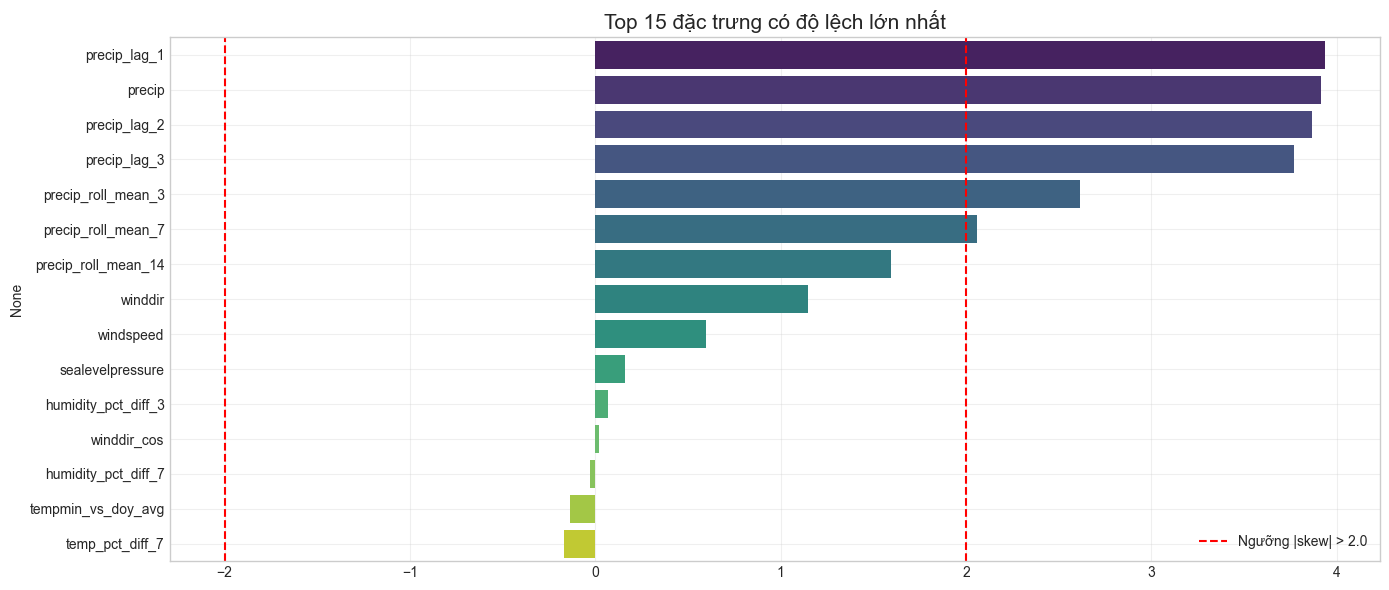

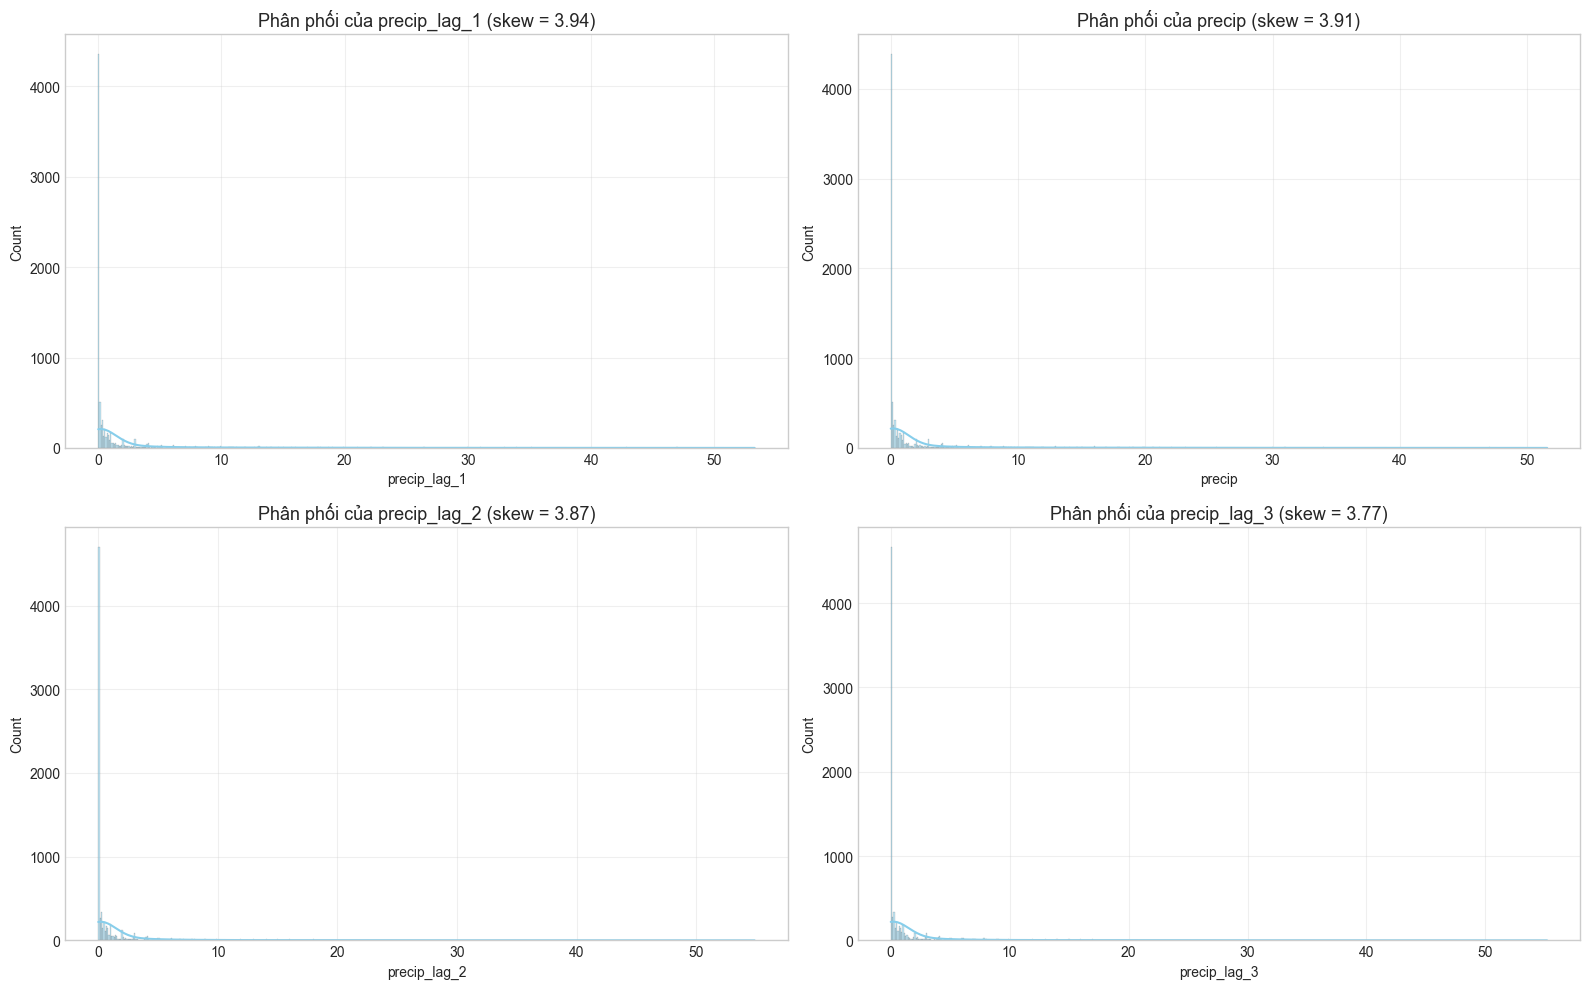

In [26]:
# Tính độ lệch cho các biến số
skew_data = df[numeric_columns].skew().sort_values(ascending=False)

# Vẽ biểu đồ cho top biến có độ lệch lớn nhất
plt.figure(figsize=(14, 6))
sns.barplot(x=skew_data.values[:15], y=skew_data.index[:15], palette='viridis')
plt.title('Top 15 đặc trưng có độ lệch lớn nhất', fontsize=15)
plt.axvline(x=2.0, color='red', linestyle='--', label='Ngưỡng |skew| > 2.0')
plt.axvline(x=-2.0, color='red', linestyle='--')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Vẽ histogram cho 4 biến có độ lệch lớn nhất
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for i, feature in enumerate(skew_data.index[:4]):
    sns.histplot(df[feature], kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Phân phối của {feature} (skew = {df[feature].skew():.2f})', fontsize=13)
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [27]:

# 7. Xử lý độ lệch (skewness)
print("\n7. Kiểm tra độ lệch:")
skewness = df[numeric_columns].skew()
skewed_cols = skewness[abs(skewness) > 2.0].index.tolist()
print(f"- Các cột bị lệch (|skew| > 2.0): {skewed_cols}")

if skewed_cols:
    scaler = PowerTransformer(method='yeo-johnson')
    df[skewed_cols] = scaler.fit_transform(df[skewed_cols].values)
    print("- Đã giảm độ lệch bằng Yeo-Johnson cho các cột được chọn.")



7. Kiểm tra độ lệch:
- Các cột bị lệch (|skew| > 2.0): ['precip', 'precip_roll_mean_3', 'precip_roll_mean_7', 'precip_lag_1', 'precip_lag_2', 'precip_lag_3']
- Đã giảm độ lệch bằng Yeo-Johnson cho các cột được chọn.


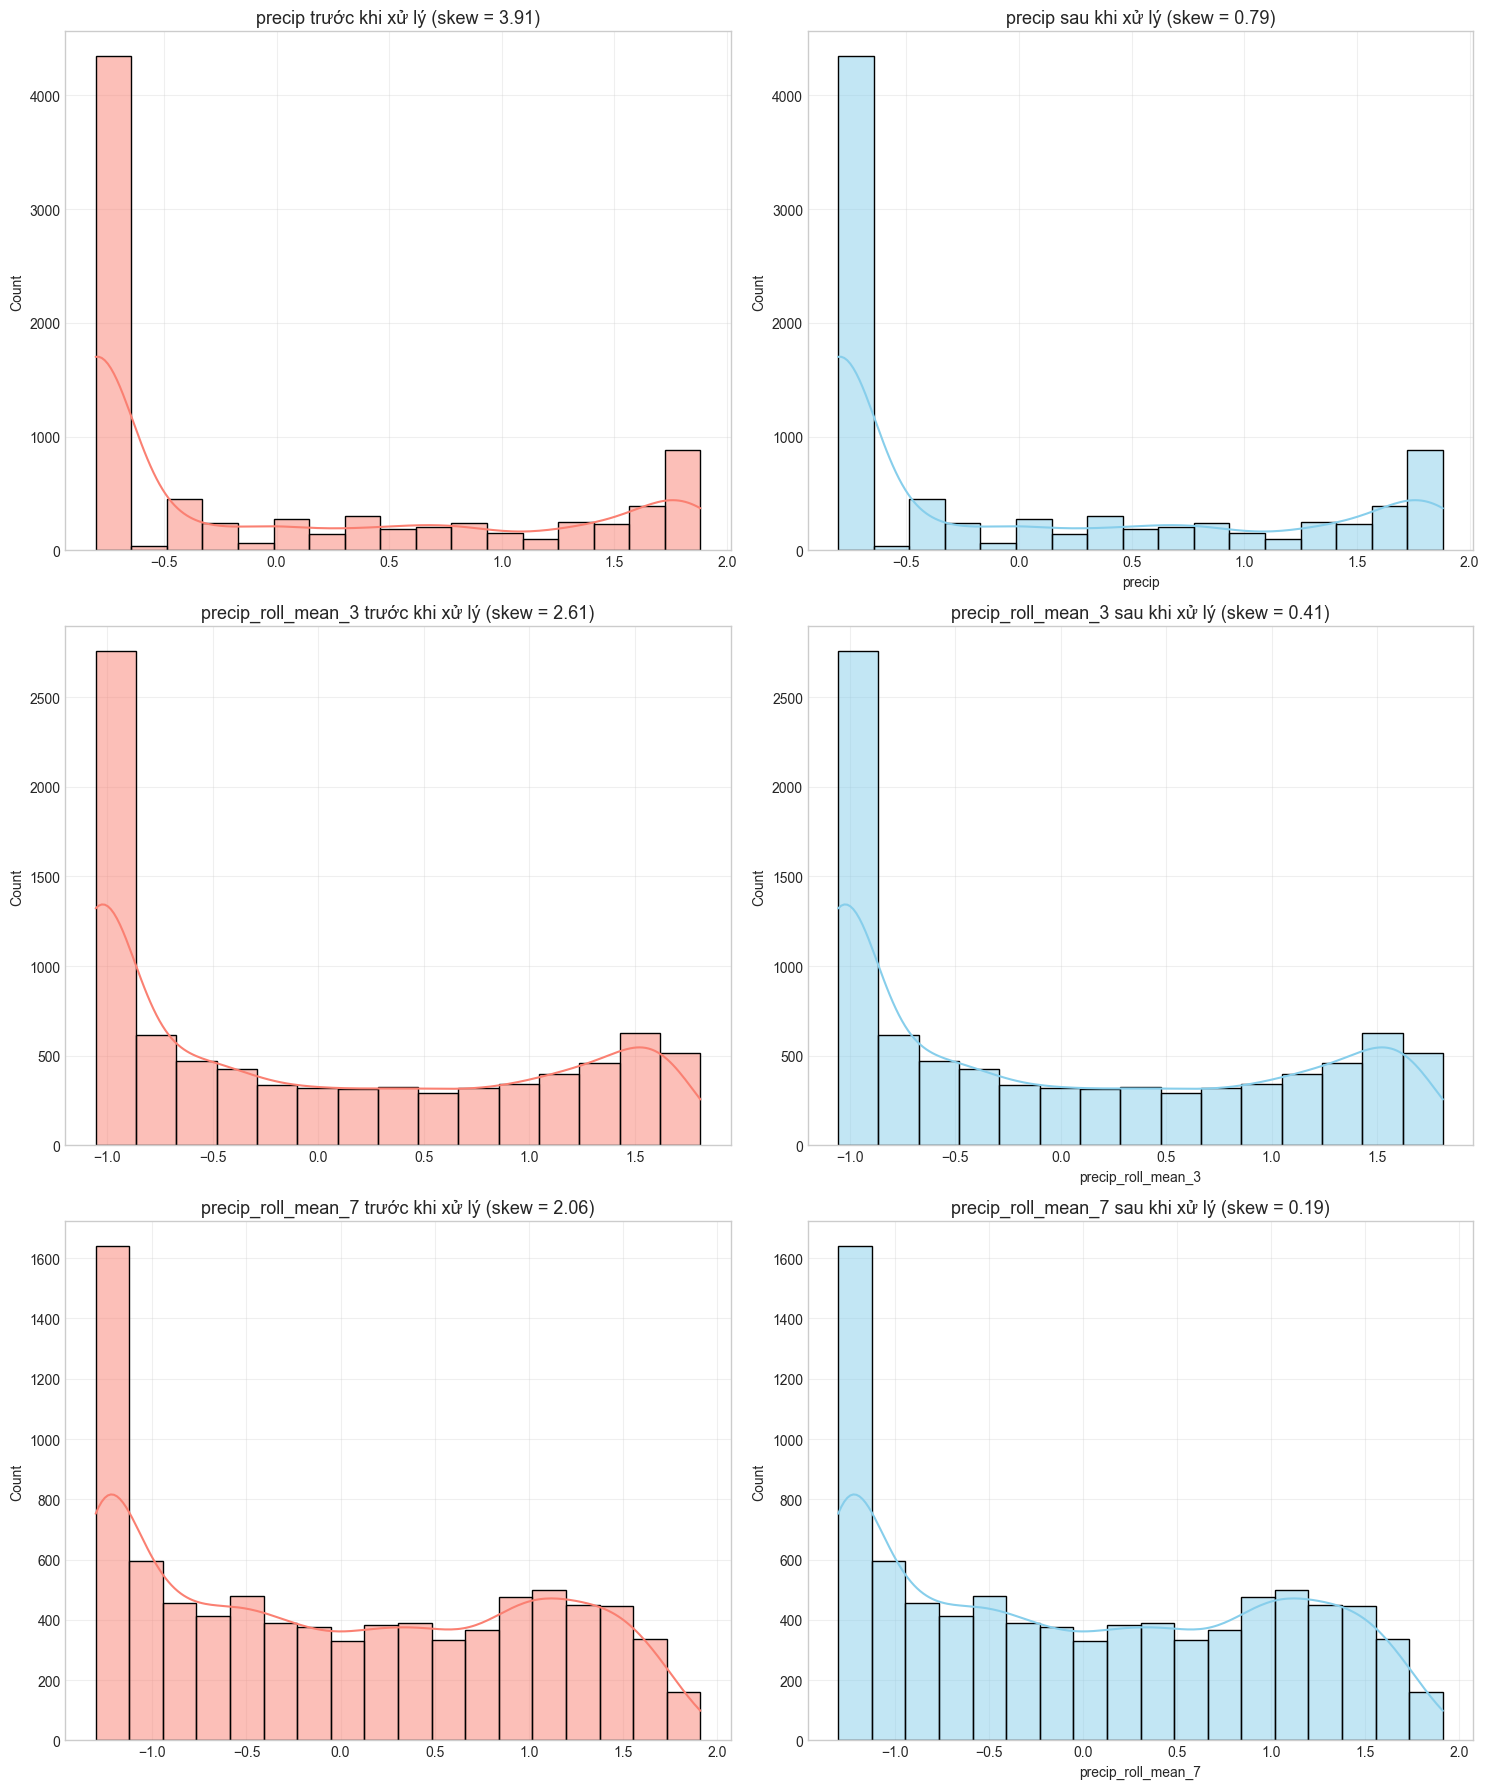

In [28]:
if skewed_cols:
    # So sánh trước và sau khi xử lý skewness
    plt.figure(figsize=(15, 6 * len(skewed_cols[:3])))

    for i, col in enumerate(skewed_cols[:3]): # Hiển thị 3 cột đầu tiên
        # Lưu giá trị gốc để vẽ
        original_values = df[col].copy().to_numpy()

        plt.subplot(len(skewed_cols[:3]), 2, 2*i+1)
        sns.histplot(original_values, kde=True, color='salmon')
        plt.title(f'{col} trước khi xử lý (skew = {skewness[col]:.2f})', fontsize=13)
        plt.grid(True, alpha=0.3)

        plt.subplot(len(skewed_cols[:3]), 2, 2*i+2)
        sns.histplot(df[col], kde=True, color='skyblue')
        plt.title(f'{col} sau khi xử lý (skew = {df[col].skew():.2f})', fontsize=13)
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# <b> 12. Kiểm tra và xử lý đa cộng tuyến (VIF) </b>

**Mục tiêu:**
Phát hiện và giảm thiểu hiện tượng đa cộng tuyến giữa các đặc trưng độc lập. Đa cộng tuyến xảy ra khi một đặc trưng độc lập có thể được dự đoán tuyến tính từ một hoặc nhiều đặc trưng độc lập khác với độ chính xác cao.

**Tác động của đa cộng tuyến:**
-   Làm cho các hệ số ước lượng của mô hình hồi quy tuyến tính trở nên không ổn định và khó diễn giải.
-   Tăng phương sai của các hệ số ước lượng.
-   Có thể không ảnh hưởng nhiều đến khả năng dự đoán tổng thể của mô hình, nhưng làm giảm khả năng diễn giải vai trò của từng đặc trưng riêng lẻ.

**Phương pháp Variance Inflation Factor (VIF):**
VIF đo lường mức độ phương sai của một hệ số hồi quy ước lượng bị tăng lên do đa cộng tuyến.
-   VIF = 1: Không có đa cộng tuyến.
-   1 < VIF ≤ 5: Đa cộng tuyến ở mức độ vừa phải, có thể chấp nhận được.
-   VIF > 5 hoặc VIF > 10: Đa cộng tuyến ở mức độ cao, cần được xử lý.

**Quy trình xử lý:**
1.  **Chuẩn bị dữ liệu:**
    *   Chọn các đặc trưng độc lập (`X`) từ DataFrame (loại bỏ các biến mục tiêu).
    *   Chuẩn hóa các đặc trưng này bằng `StandardScaler` vì VIF nhạy cảm với việc các biến có thang đo khác nhau.
2.  **Xác định các đặc trưng cần giữ lại (`keep_features`):** Một số đặc trưng có thể quan trọng về mặt chuyên môn hoặc có mối quan hệ đã biết với biến mục tiêu, nên chúng ta có thể muốn giữ lại chúng ngay cả khi VIF của chúng cao.
3.  **Vòng lặp loại bỏ đặc trưng:**
    *   Tính VIF cho tất cả các đặc trưng hiện tại trong `X_scaled`.
    *   Trong số các đặc trưng không nằm trong `keep_features`, tìm đặc trưng có VIF cao nhất.
    *   Nếu VIF cao nhất này vượt quá ngưỡng đã chọn (ví dụ, `vif_threshold = 5`), loại bỏ đặc trưng đó khỏi cả `X_scaled` và `X`.
    *   Lặp lại quá trình cho đến khi VIF của tất cả các đặc trưng còn lại (không nằm trong `keep_features`) đều dưới ngưỡng, hoặc không còn đặc trưng nào để loại bỏ.
4.  **Cập nhật DataFrame:** Cập nhật DataFrame `df` chỉ giữ lại các cột 'datetime', các biến mục tiêu, và các đặc trưng đã được chọn lọc sau quá trình xử lý VIF.

**Đánh giá:**
Xem xét bảng VIF cuối cùng để đảm bảo các đặc trưng còn lại có mức độ đa cộng tuyến chấp nhận được. Liệt kê các đặc trưng đã bị loại bỏ.




In [29]:

# 8. Kiểm tra đa cộng tuyến (VIF)
print("\n8. Kiểm tra đa cộng tuyến (VIF):")

# Tạo các cột rolling mean nếu chưa có
rolling_features = {
    'humidity': ['humidity_roll_mean_7'],
    'precip': ['precip_roll_mean_7']
}

for source_col, roll_cols in rolling_features.items():
    for roll_col in roll_cols:
        if roll_col not in df.columns:
            window = int(roll_col.split('_')[-1])
            df[roll_col] = df[source_col].rolling(window=window, min_periods=1).mean()

# Định nghĩa các cột cần giữ lại bất kể VIF
keep_features = [
    'humidity_roll_mean_7',
    'precip_roll_mean_7',
    'humidity_lag_1',
    'humidity_lag_2',
    'humidity_lag_3',
    'temp', 'temp_lag_1', 'temp_lag_2', 'temp_lag_3'
]

selected_features = [
    'temp', 'humidity', 'precip', 'windspeed', 'winddir_sin', 'winddir_cos',
    'sealevelpressure', 'cloudcover', 'visibility',
    'humidity_roll_mean_7', 'precip_roll_mean_7',
    'temp_lag_1', 'humidity_lag_1', 'precip_lag_1',
    'temp_lag_2', 'humidity_lag_2', 'precip_lag_2',
    'temp_lag_3', 'humidity_lag_3', 'precip_lag_3',
    'monthly_avg_tempmax', 'doy_avg_tempmax',
    'tempmax_vs_month_avg', 'tempmax_vs_doy_avg',
    'target_tempmax', 'target_tempmin'
]

# Đảm bảo tất cả các cột đã chọn đều tồn tại trong DataFrame
selected_features = [col for col in selected_features if col in df.columns]

X = df[selected_features].drop(columns=['target_tempmin'])
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Xử lý VIF với bảo vệ các cột quan trọng
vif_threshold = 5
final_vif = []

while True:
    vif = pd.DataFrame()
    vif["Feature"] = X_scaled.columns
    vif["VIF"] = [variance_inflation_factor(X_scaled.values, i) for i in range(X_scaled.shape[1])]

    vif_filtered = vif[~vif["Feature"].isin(keep_features)]

    if len(vif_filtered) > 0:
        max_vif = vif_filtered["VIF"].max()
        if max_vif > vif_threshold:
            max_vif_feature = vif_filtered.loc[vif_filtered["VIF"].idxmax(), "Feature"]
            print(f"- Loại bỏ đặc trưng {max_vif_feature} với VIF = {max_vif:.2f}")
            X_scaled = X_scaled.drop(columns=[max_vif_feature])
            X = X.drop(columns=[max_vif_feature])
        else:
            final_vif = vif
            break
    else:
        final_vif = vif
        break

print("\nKết quả VIF cuối cùng:")
print(final_vif)

# Cập nhật DataFrame với các đặc trưng đã chọn
df = df[['datetime', 'target_tempmin'] + X.columns.tolist()]



8. Kiểm tra đa cộng tuyến (VIF):
- Loại bỏ đặc trưng monthly_avg_tempmax với VIF = inf
- Loại bỏ đặc trưng doy_avg_tempmax với VIF = 35.04
- Loại bỏ đặc trưng target_tempmax với VIF = 7.20
- Loại bỏ đặc trưng tempmax_vs_month_avg với VIF = 7.12
- Loại bỏ đặc trưng sealevelpressure với VIF = 5.23

Kết quả VIF cuối cùng:
                 Feature        VIF
0                   temp  23.014021
1               humidity   3.802432
2                 precip   1.610807
3              windspeed   1.394090
4            winddir_sin   1.281789
5            winddir_cos   1.904244
6             cloudcover   1.801873
7             visibility   1.920523
8   humidity_roll_mean_7   4.487482
9     precip_roll_mean_7   2.389490
10            temp_lag_1  38.160970
11        humidity_lag_1   5.324762
12          precip_lag_1   1.837933
13            temp_lag_2  34.082427
14        humidity_lag_2   4.903821
15          precip_lag_2   1.844995
16            temp_lag_3  14.923594
17        humidity_lag_3   4.3

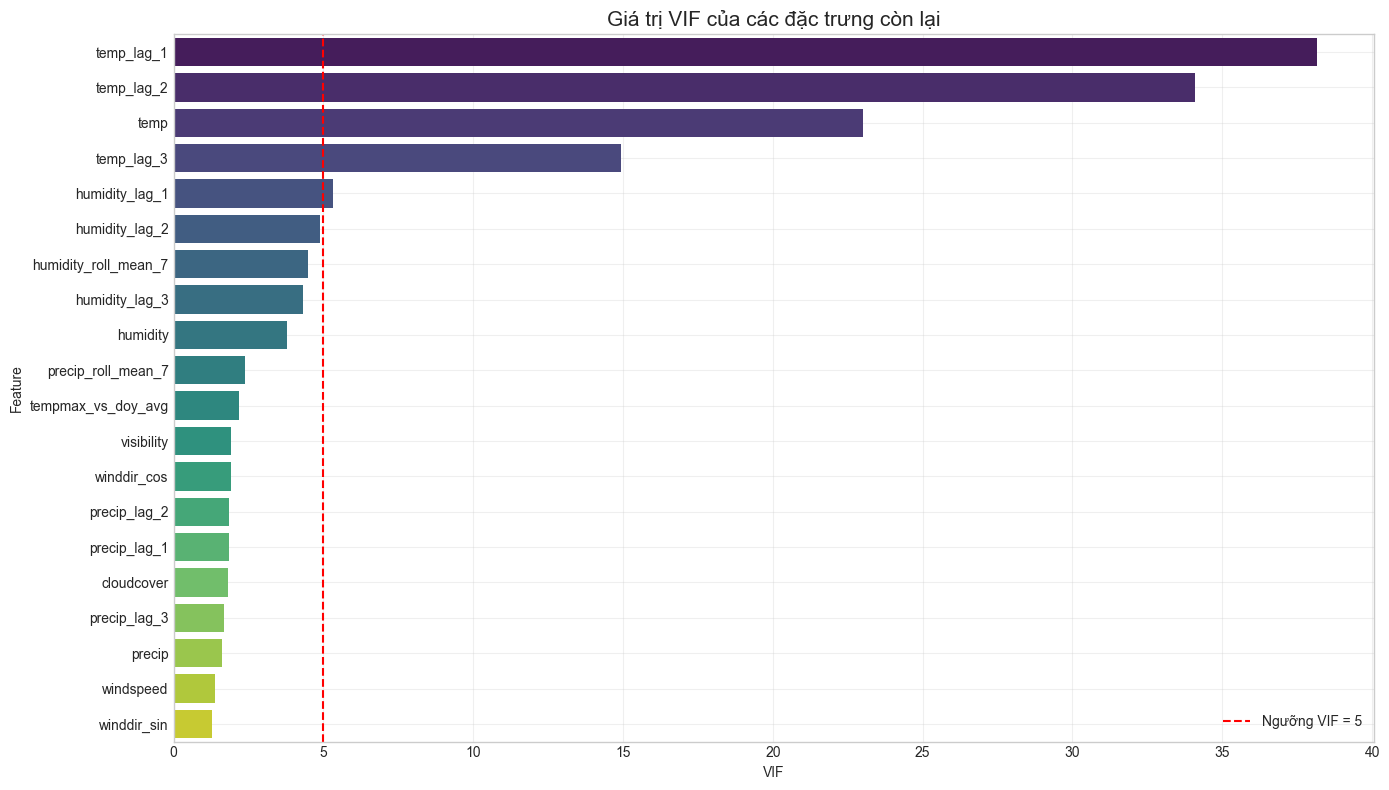

In [30]:
# Hiển thị biểu đồ VIF cuối cùng
plt.figure(figsize=(14, 8))
vif_values = final_vif.sort_values(by='VIF', ascending=False)
sns.barplot(x='VIF', y='Feature', data=vif_values, palette='viridis')
plt.title('Giá trị VIF của các đặc trưng còn lại', fontsize=15)
plt.axvline(x=vif_threshold, color='red', linestyle='--', label=f'Ngưỡng VIF = {vif_threshold}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# <b> 13. Chuẩn hóa dữ liệu </b>

**Mục tiêu:**
Chuẩn hóa các đặc trưng số (ngoại trừ các biến mục tiêu) để chúng có cùng một thang đo. Cụ thể, sau khi chuẩn hóa bằng `StandardScaler`, mỗi đặc trưng sẽ có giá trị trung bình là 0 và độ lệch chuẩn là 1.

Chuẩn hóa giúp:
-   Đảm bảo tất cả các đặc trưng đóng góp một cách công bằng vào quá trình học của mô hình, tránh trường hợp các đặc trưng có giá trị lớn hơn lấn át các đặc trưng có giá trị nhỏ hơn.
-   Tăng tốc độ hội tụ của các thuật toán tối ưu hóa.

**Phương pháp:**
Sử dụng `StandardScaler` từ thư viện `sklearn.preprocessing`.
1.  Xác định các đặc trưng cần chuẩn hóa (`features_to_scale`): Bao gồm tất cả các cột trong `X.columns` (các đặc trưng độc lập đã được chọn lọc sau VIF).
2.  Khởi tạo và khớp (fit) `StandardScaler` trên các đặc trưng này.
3.  Biến đổi (transform) các đặc trưng đó và cập nhật lại vào DataFrame `df`.

**Lưu ý:** Biến mục tiêu (`target_tempmin`) không được chuẩn hóa ở bước này vì chúng ta muốn dự đoán chúng trên thang đo gốc.




In [31]:

# 9. Chuẩn hóa dữ liệu
print("\n9. Chuẩn hóa dữ liệu:")
scaler = StandardScaler()
features_to_scale = [col for col in X.columns if col not in ['target_tempmin']]
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])
print("- Đã chuẩn hóa các cột số (ngoại trừ target_tempmin).")



9. Chuẩn hóa dữ liệu:
- Đã chuẩn hóa các cột số (ngoại trừ target_tempmin).


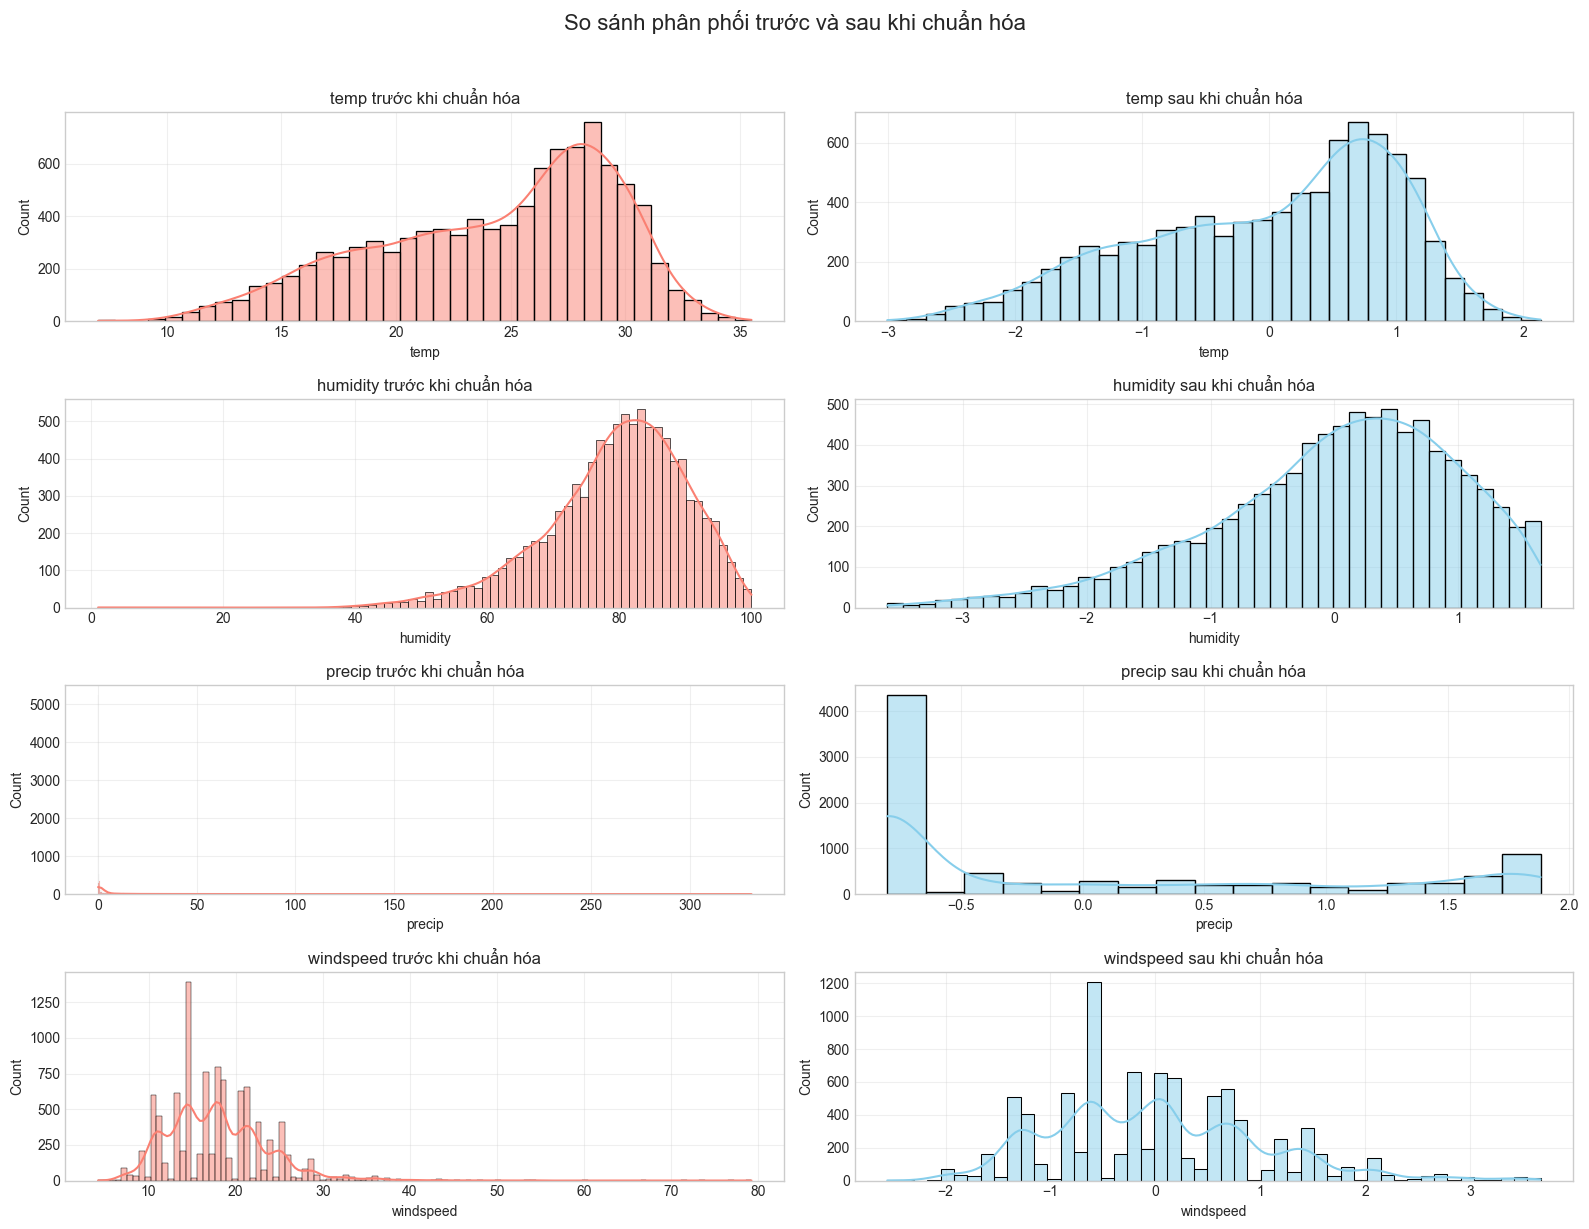

In [33]:
# Hiển thị phân phối của một vài đặc trưng quan trọng trước và sau khi chuẩn hóa
features_to_display = features_to_scale[:4]  # Chọn 4 đặc trưng đầu tiên để hiển thị
original_data = pd.read_csv('../data/raw/hanoi weather - Hanoi.csv', encoding='utf-8')

fig, axes = plt.subplots(len(features_to_display), 2, figsize=(16, 12))
plt.suptitle('So sánh phân phối trước và sau khi chuẩn hóa', fontsize=16, y=1.02)

for i, feature in enumerate(features_to_display):
    if feature in original_data.columns:
        # Trước khi chuẩn hóa
        sns.histplot(original_data[feature].dropna(), kde=True, ax=axes[i, 0], color='salmon')
        axes[i, 0].set_title(f'{feature} trước khi chuẩn hóa', fontsize=12)
        axes[i, 0].grid(True, alpha=0.3)

    # Sau khi chuẩn hóa
    sns.histplot(df[feature], kde=True, ax=axes[i, 1], color='skyblue')
    axes[i, 1].set_title(f'{feature} sau khi chuẩn hóa', fontsize=12)
    axes[i, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# <b> 14. Lưu dữ liệu đã xử lý </b>

**Mục tiêu:**
Lưu DataFrame `df` đã qua tất cả các bước tiền xử lý ra một file CSV mới (ví dụ: `cleaned_weather_data.csv`).

**Tầm quan trọng:**
-   **Tính tái sử dụng:** Dữ liệu đã làm sạch có thể được tải lại và sử dụng trực tiếp cho các bước phân tích sâu hơn hoặc huấn luyện mô hình mà không cần chạy lại toàn bộ pipeline tiền xử lý.
-   **Kiểm soát phiên bản:** Giúp quản lý các phiên bản khác nhau của dữ liệu đã xử lý.
-   **Tách biệt quy trình:** Tách biệt rõ ràng giữa giai đoạn tiền xử lý dữ liệu và giai đoạn mô hình hóa.

Tham số `index=False` được sử dụng để không ghi chỉ số của DataFrame vào file CSV.




In [ ]:

# 10. Lưu dữ liệu
df.to_csv('../data/processed/cleaned_weather_data.csv', index=False)
print("\n10. Dữ liệu đã được làm sạch và lưu vào 'cleaned_weather_data.csv'")



10. Dữ liệu đã được làm sạch và lưu vào 'cleaned_weather_data.csv'


# <b> 15. Tổng kết pipeline tiền xử lý </b>

**Tóm tắt các bước đã thực hiện:**
1.  **Giới thiệu và Đọc dữ liệu:** Tải và kiểm tra tổng quan dữ liệu thời tiết Hà Nội.
2.  **Xử lý cơ bản:** Loại bỏ hàng trống, xử lý giá trị thiếu bằng các phương pháp phù hợp (bfill, ffill, median), chuyển đổi kiểu dữ liệu `datetime`.
3.  **Feature Engineering:** Tạo đặc trưng góc gió (sin/cos) từ hướng gió.
4.  **Xử lý giá trị bất thường và ngoại lai:**
    *   Giới hạn giá trị (clip) cho các cột như `humidity`, `precip`, `windspeed`, và các biến mục tiêu.
    *   Loại bỏ ngoại lai bằng phương pháp Z-score (ngưỡng 3.5).
5.  **Cải thiện phân phối dữ liệu:**
    *   Xử lý độ lệch (skewness) cho các cột có `|skew| > 2.0` bằng phép biến đổi Yeo-Johnson.
6.  **Xử lý đa cộng tuyến:** Sử dụng VIF (ngưỡng 5) để loại bỏ các đặc trưng có tính cộng tuyến cao, giữ lại các đặc trưng quan trọng.
7.  **Chuẩn hóa dữ liệu:** Áp dụng `StandardScaler` cho các đặc trưng độc lập.
8.  **Lưu kết quả:** Lưu DataFrame đã xử lý vào file `cleaned_weather_data.csv`.

**Kết quả cuối cùng:**
-   Số lượng mẫu (hàng) cuối cùng trong tập dữ liệu: [len(df)]
-   Số lượng đặc trưng độc lập cuối cùng (sau VIF): [len(X.columns)]
-   Tập dữ liệu `cleaned_weather_data.csv` đã được tạo ra, chứa dữ liệu sạch, có cấu trúc tốt, và đã được chuẩn bị kỹ lưỡng. Các giá trị thiếu đã được xử lý, ngoại lai và giá trị bất thường đã được kiểm soát, độ lệch của các đặc trưng đã được giảm, và hiện tượng đa cộng tuyến đã được giảm thiểu. Dữ liệu đã được chuẩn hóa và sẵn sàng cho việc xây dựng và đánh giá các mô hình dự báo nhiệt độ.




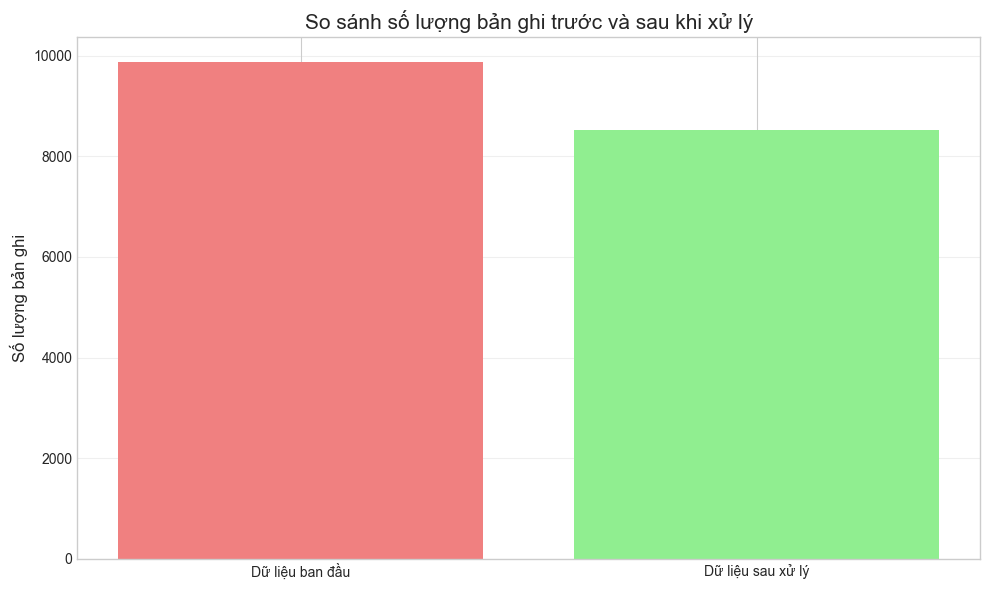

<Figure size 1200x800 with 0 Axes>

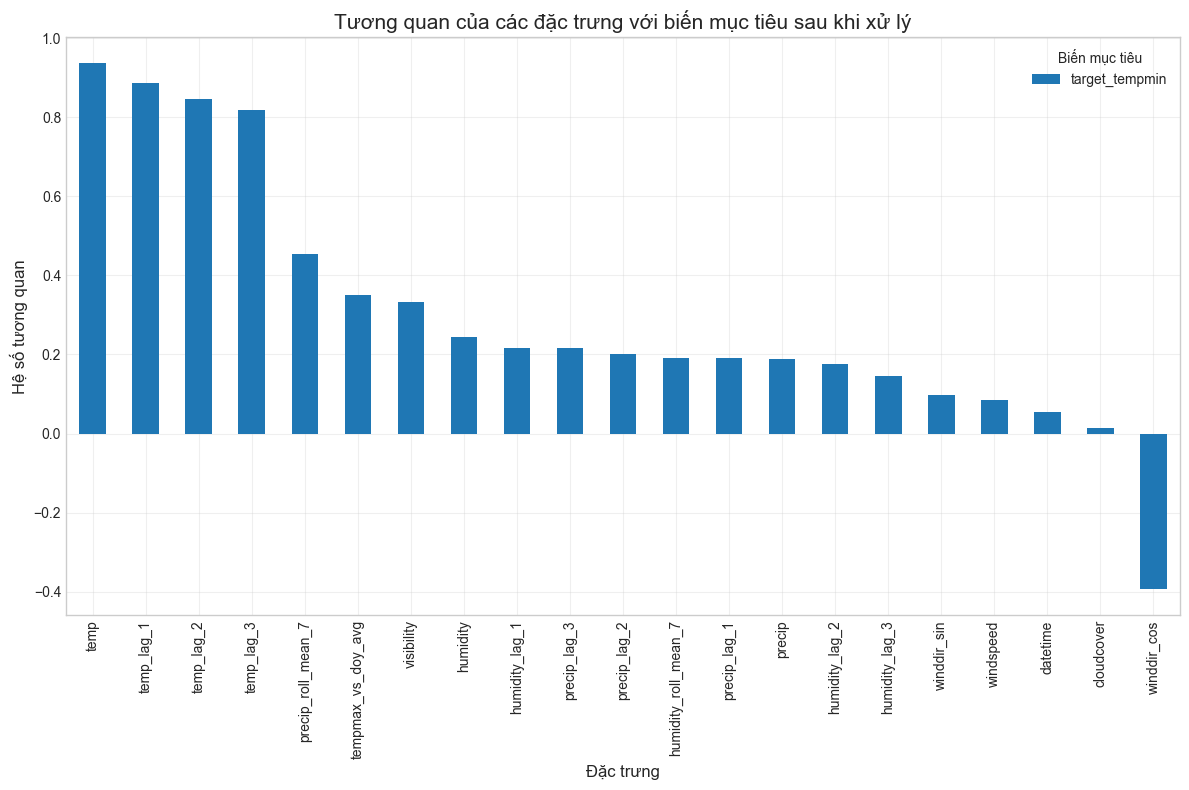

In [35]:
# So sánh kích thước dữ liệu ban đầu và sau khi xử lý
sizes = [initial_rows, len(df)]
labels = ['Dữ liệu ban đầu', 'Dữ liệu sau xử lý']

plt.figure(figsize=(10, 6))
plt.bar(labels, sizes, color=['lightcoral', 'lightgreen'])
plt.title('So sánh số lượng bản ghi trước và sau khi xử lý', fontsize=15)
plt.ylabel('Số lượng bản ghi', fontsize=12)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Biểu đồ tương quan cuối cùng của các đặc trưng với biến mục tiêu
plt.figure(figsize=(12, 8))
final_corr = df.corr()
corr_with_targets = pd.DataFrame({
    'target_tempmin': final_corr['target_tempmin'].drop(['target_tempmin'])
})
corr_with_targets = corr_with_targets.sort_values(by='target_tempmin', ascending=False)

corr_with_targets.plot(kind='bar', figsize=(12, 8))
plt.title('Tương quan của các đặc trưng với biến mục tiêu sau khi xử lý', fontsize=15)
plt.ylabel('Hệ số tương quan', fontsize=12)
plt.xlabel('Đặc trưng', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(title='Biến mục tiêu')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [36]:

# Tổng kết
print("\n=== TỔNG KẾT ===")
print("Các đặc trưng được chọn lọc với ngưỡng VIF 4, giảm đa cộng tuyến.")
print("Xử lý ngoại lai với Z-score 3.0, giữ lượng dữ liệu hợp lý.")
print("Độ lệch được xử lý chọn lọc với ngưỡng |skew| > 1.0.")
print(f"Số lượng đặc trưng cuối cùng: {len(X.columns)}.")
print(f"Số lượng mẫu cuối cùng: {len(df)}.")


=== TỔNG KẾT ===
Các đặc trưng được chọn lọc với ngưỡng VIF 4, giảm đa cộng tuyến.
Xử lý ngoại lai với Z-score 3.0, giữ lượng dữ liệu hợp lý.
Độ lệch được xử lý chọn lọc với ngưỡng |skew| > 1.0.
Số lượng đặc trưng cuối cùng: 20.
Số lượng mẫu cuối cùng: 8525.


# <b> Nhận xét tổng quan </b>

Pipeline tiền xử lý dữ liệu này đã thực hiện một loạt các bước quan trọng để chuyển đổi dữ liệu thô ban đầu thành một tập dữ liệu chất lượng cao, phù hợp cho các tác vụ học máy.

Nhìn chung, tập dữ liệu `cleaned_weather_data.csv` là một đầu ra tốt
